<p style='font-family: times, serif; font-size:25pt; font-style:bold; color:white;'>
    SHyTCWaves - Application for bulk parameters
</p>

<p style='font-family: times, serif; font-size:16pt; font-style:bold; color:white;'>
    TC - historical tracks
</p>

<hr size="5"/>

<div class="alert-warning">
<b>Info:</b> Here SHyTCWaves runs for the defined track and in the area defined below
</div>

<style>
.alert-warning {
    background-color: #ffcccb; /* Color de fondo rojito claro */
    color: #8b0000; /* Color del texto rojo oscuro */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #f08080; /* Borde rojo claro */
}
</style>

In [1]:
import warnings

warnings.filterwarnings("ignore")

# common
import os
import os.path as op
import time

# pip
import numpy as np
import xarray as xr

# shytcwaves
from bluemath_tk.tcs.tracks import check_and_plot_track_data, resample_storm_6h
from bluemath_tk.tcs.shytcwaves import historic2shytcwaves_cluster
from utils.plotting import plot_storm_track, plot_swath_shytcwaves, plot_hs_tp_point

###  **1. Load data**

<div class="alert-warning">
<b>Info:</b> Here SHyTCWaves runs for the defined track and in the area defined below
</div>

<style>
.alert-warning {
    background-color: #fffacd; /* Color de fondo amarillito más oscuro */
    color: #8b8000; /* Color del texto amarillo oscuro */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #f0e68c; /* Borde amarillo oscuro */
}
</style>

In [2]:
# IBTrACS
p_tracks = "https://geoocean.sci.unican.es/thredds/dodsC/geoceanData/GEOOCEAN/IBTrACS.ALL.v04r00.nc"
xds_tcs = xr.open_dataset(p_tracks)
xds_tcs

<xarray.Dataset> Size: 8GB
Dimensions:           (storm: 13557, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] 39MB ...
    lat               (storm, date_time) float32 20MB ...
    lon               (storm, date_time) float32 20MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 54kB ...
    sid               (storm) |S64 868kB ...
    season            (storm) float32 54kB ...
    number            (storm) int16 27kB ...
    basin             (storm, date_time) |S64 312MB ...
    subbasin          (storm, date_time) |S64 312MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 20MB ...
    reunion_gust_per  (storm, date_time) float32 20MB ...
    usa_seahgt        (storm, date_time) float32 20MB ...
    usa_searad        (storm, date_time, quadrant) float32 78MB ...
    storm_speed       (storm, date_time) float32 20MB ...
    storm_dir         (storm, date_time) float32 20MB ...
Attributes: (12/52)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3
    DODS.strlen:                2
    DODS.dimName:               char2

In [3]:
output_folder_name = "outputs"
output_path = op.join(os.getcwd(), output_folder_name)
os.makedirs(output_path, exist_ok=True)

###  **2. Storm selection**

<div class="alert-warning">
<b>Info:</b> Here SHyTCWaves runs for the defined track and in the area defined below
</div>

<style>
.alert-warning {
    background-color: #d3d3e6; /* Color de fondo azul más seco y clarito */
    color: #00008b; /* Color del texto azul oscuro */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #b0c4de; /* Borde azul acero claro */
}
</style>

The track can be selected by:
- Position 
- Name and year

In [4]:
# to select tc from name and year
name_tc, year_tc = "KATRINA", 2005
itc = np.where(
    (xds_tcs["name"].values.astype("str") == name_tc)
    & (xds_tcs.isel(date_time=0).time.dt.year.values == year_tc)
)[0]
storm = xds_tcs.isel(storm=itc).squeeze().load()
storm

<xarray.Dataset> Size: 556kB
Dimensions:           (date_time: 360, quadrant: 4)
Coordinates:
    time              (date_time) datetime64[ns] 3kB 2005-08-23T18:00:00.0000...
    lat               (date_time) float32 1kB 23.1 23.25 23.4 ... nan nan nan
    lon               (date_time) float32 1kB -75.1 -75.4 -75.7 ... nan nan nan
Dimensions without coordinates: date_time, quadrant
Data variables: (12/147)
    numobs            float32 4B 64.0
    sid               |S64 64B b'2005236N23285'
    season            float32 4B 2.005e+03
    number            int16 2B 61
    basin             (date_time) |S64 23kB b'NA' b'NA' b'NA' ... b'' b'' b''
    subbasin          (date_time) |S64 23kB b'NA' b'NA' b'NA' ... b'' b'' b''
    ...                ...
    reunion_gust      (date_time) float32 1kB nan nan nan nan ... nan nan nan
    reunion_gust_per  (date_time) float32 1kB nan nan nan nan ... nan nan nan
    usa_seahgt        (date_time) float32 1kB nan nan nan nan ... nan nan nan
    usa_searad        (date_time, quadrant) float32 6kB nan nan nan ... nan nan
    storm_speed       (date_time) float32 1kB 6.0 6.0 6.0 6.0 ... nan nan nan
    storm_dir         (date_time) float32 1kB 298.0 299.0 302.0 ... nan nan nan
Attributes: (12/52)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3
    DODS.strlen:                2
    DODS.dimName:               char2

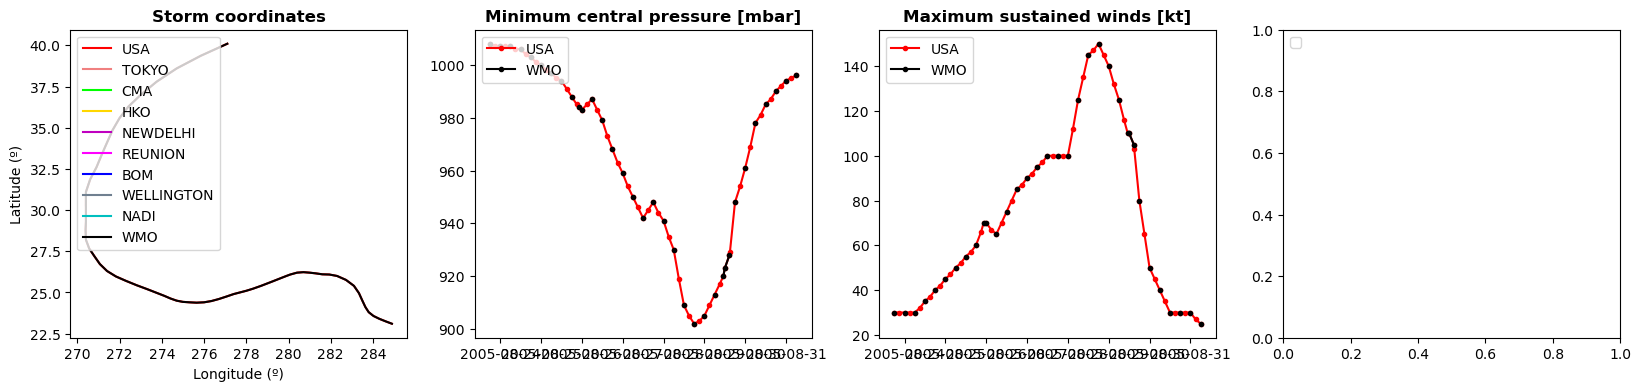

In [5]:
# storm = xr.open_dataset("outputs/ibtracs_oahu.nc").isel(storm=1)
storm_year = int(storm.season.values)

name = str(storm.name.values)[2:-1]
year = storm.time[0].dt.year.values

# plot IBTrACS data
fig = check_and_plot_track_data(storm)

In [6]:
# convert bytes to str
storm

<xarray.Dataset> Size: 556kB
Dimensions:           (date_time: 360, quadrant: 4)
Coordinates:
    time              (date_time) datetime64[ns] 3kB 2005-08-23T18:00:00.0000...
    lat               (date_time) float32 1kB 23.1 23.25 23.4 ... nan nan nan
    lon               (date_time) float32 1kB -75.1 -75.4 -75.7 ... nan nan nan
Dimensions without coordinates: date_time, quadrant
Data variables: (12/147)
    numobs            float32 4B 64.0
    sid               |S64 64B b'2005236N23285'
    season            float32 4B 2.005e+03
    number            int16 2B 61
    basin             (date_time) |S64 23kB b'NA' b'NA' b'NA' ... b'' b'' b''
    subbasin          (date_time) |S64 23kB b'NA' b'NA' b'NA' ... b'' b'' b''
    ...                ...
    reunion_gust      (date_time) float32 1kB nan nan nan nan ... nan nan nan
    reunion_gust_per  (date_time) float32 1kB nan nan nan nan ... nan nan nan
    usa_seahgt        (date_time) float32 1kB nan nan nan nan ... nan nan nan
    usa_searad        (date_time, quadrant) float32 6kB nan nan nan ... nan nan
    storm_speed       (date_time) float32 1kB 6.0 6.0 6.0 6.0 ... nan nan nan
    storm_dir         (date_time) float32 1kB 298.0 299.0 302.0 ... nan nan nan
Attributes: (12/52)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3
    DODS.strlen:                2
    DODS.dimName:               char2

In [7]:
# NOTE
# resample to 6H
# it may be necessary only for some tracks
storm = resample_storm_6h(storm)
storm["lon"] = (
    ("time"),
    np.where(storm["lon"].values < 0, storm["lon"].values + 360, storm["lon"].values),
)

###  **3. SHyTCWaves**

<div class="alert-warning">
<b>Info:</b> Here SHyTCWaves runs for the defined track and in the area defined below
</div>

<style>
.alert-warning {
    background-color: #f0fff0; /* Color de fondo verdecito muy claro */
    color: #006400; /* Color del texto verde oscuro */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #98fb98; /* Borde verde claro */
}
</style>

In [8]:
# Are sourrounding storm to extract bulk parameters
extra_area = 12
area = [
    storm.lon.min().values - extra_area,
    storm.lon.max().values + extra_area,
    storm.lat.min().values - extra_area,
    storm.lat.max().values + extra_area,
]

In [10]:
t0 = time.time()

# project path
path_proj = op.join(output_path, "tc_{0}_{1}_{2}".format(itc, name, year))
if not op.isdir(path_proj):
    os.mkdir(path_proj)

tc_name = name + "_hist"
center = "WMO"

swath_resolution = 0.5
lon = np.arange(area[0], area[1], swath_resolution)
lat = np.arange(area[2], area[3], swath_resolution)

historic2shytcwaves_cluster(
    path_proj,
    tc_name,
    storm,
    center,
    lon,
    lat,
    calibration=True,
    extract_bulk=True,
)

print(f"Elapsed time: {time.time() - t0} s")

Elapsed time: 0.0011646747589111328 s


###  **4. Plotting**

<div class="alert-warning">
<b>Info:</b> Plotting results - Maps and timeseries
</div>

<style>
.alert-warning {
    background-color: #e6e6fa; 
    color: #4b0082; /* text */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #dda0dd; 
}
</style>

In [11]:
# Load results
xds_bulk = xr.open_dataset(op.join(path_proj, "{0}_xds_shy_bulk.nc".format(tc_name)))
xds_bulk

<xarray.Dataset> Size: 546MB
Dimensions:    (case: 26, time: 198, point: 6232)
Coordinates:
  * case       (case) int64 208B 0 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
  * time       (time) datetime64[ns] 2kB 2005-08-24T06:00:00 ... 2005-09-01T1...
Dimensions without coordinates: point
Data variables:
    hs         (case, point, time) float64 257MB ...
    tp         (case, point, time) float64 257MB ...
    lon        (point) float64 50kB ...
    lat        (point) float64 50kB ...
    ix_near    (case, point) float64 1MB ...
    pos_nonan  (case, point) float64 1MB ...
    bmu        (point, time) float64 10MB ...
    hsbmu      (point, time) float64 10MB ...
    tpbmu      (point, time) float64 10MB ...
    hswath     (point) float64 50kB ...
    tswath     (point) float64 50kB ...

<div class="alert-warning">
<b>Info:</b> Plot Storm Track
</div>

<style>
.alert-warning {
    background-color: #ffe4e1; /* Color de fondo rosita claro */
    color: #c71585; /* Color del texto rosa fuerte */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #ffb6c1; /* Borde rosa claro */
}
</style>

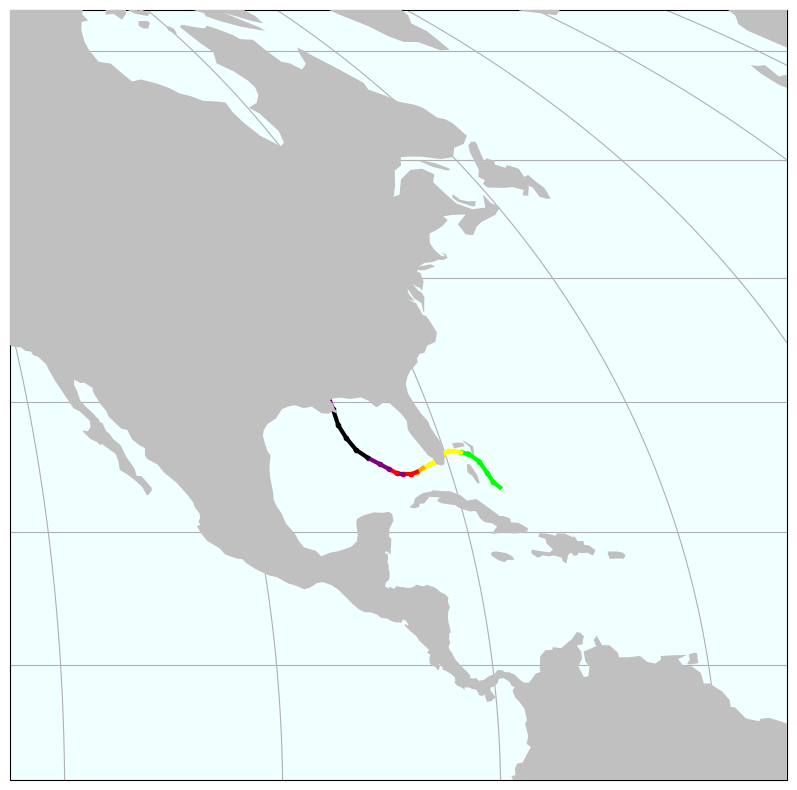

In [12]:
plot_storm_track(storm, area, itc, path_proj)

<div class="alert-warning">
<b>Info:</b> Plot Swath for Hs and Tp
</div>

<style>
.alert-warning {
    background-color: #ffe4e1; /* Color de fondo rosita claro */
    color: #c71585; /* Color del texto rosa fuerte */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #ffb6c1; /* Borde rosa claro */
}
</style>

Hs

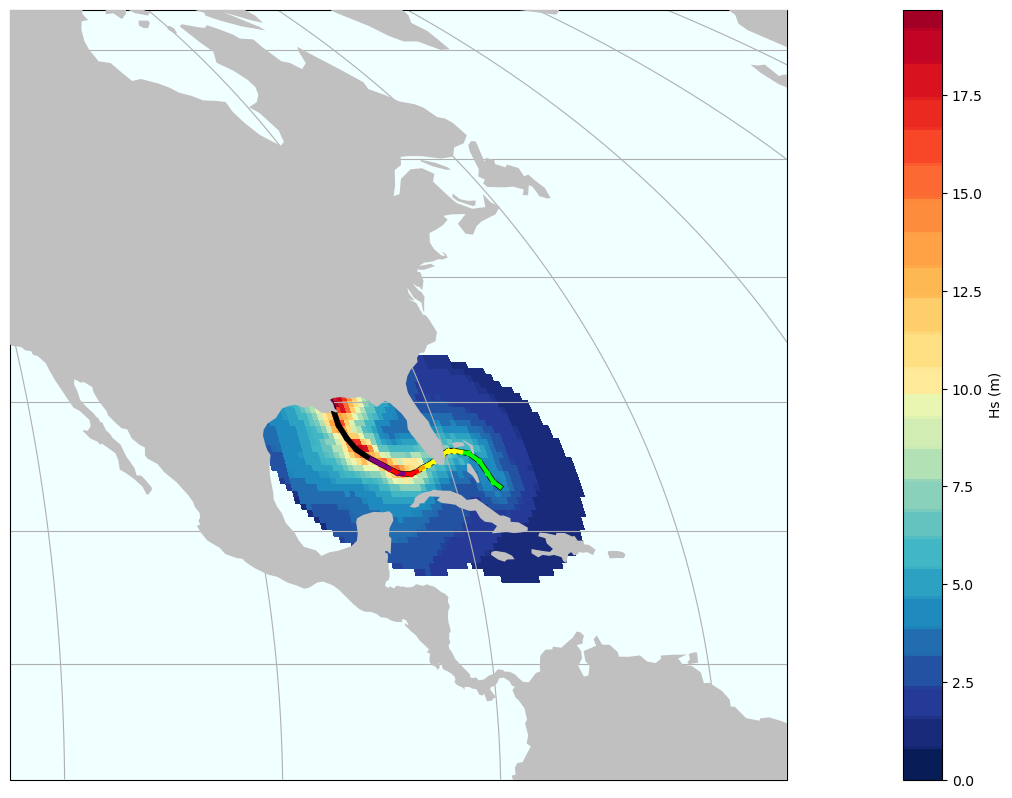

In [13]:
plot_swath_shytcwaves(storm, xds_bulk, area, itc, path_proj, var="hswath", vmax=None)

Tp

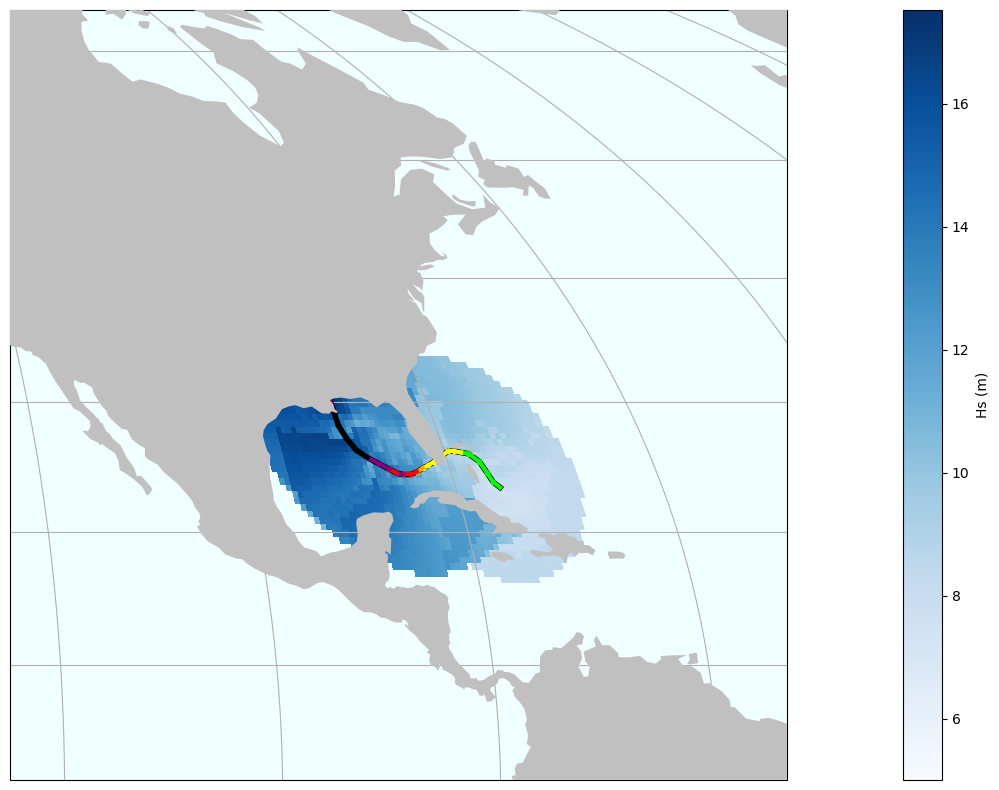

In [14]:
plot_swath_shytcwaves(
    storm, xds_bulk, area, itc, path_proj, var="tswath", vmin=5, vmax=None, cmap="Blues"
)

<div class="alert-warning">
<b>Info:</b> Plot Time evolution of Hs and Tp in a selected point
</div>

<style>
.alert-warning {
    background-color: #ffe4e1; /* Color de fondo rosita claro */
    color: #c71585; /* Color del texto rosa fuerte */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #ffb6c1; /* Borde rosa claro */
}
</style>

In [15]:
lon, lat = 272, 25  # 360 - 88.23, 29.20, Buoy BELOW!

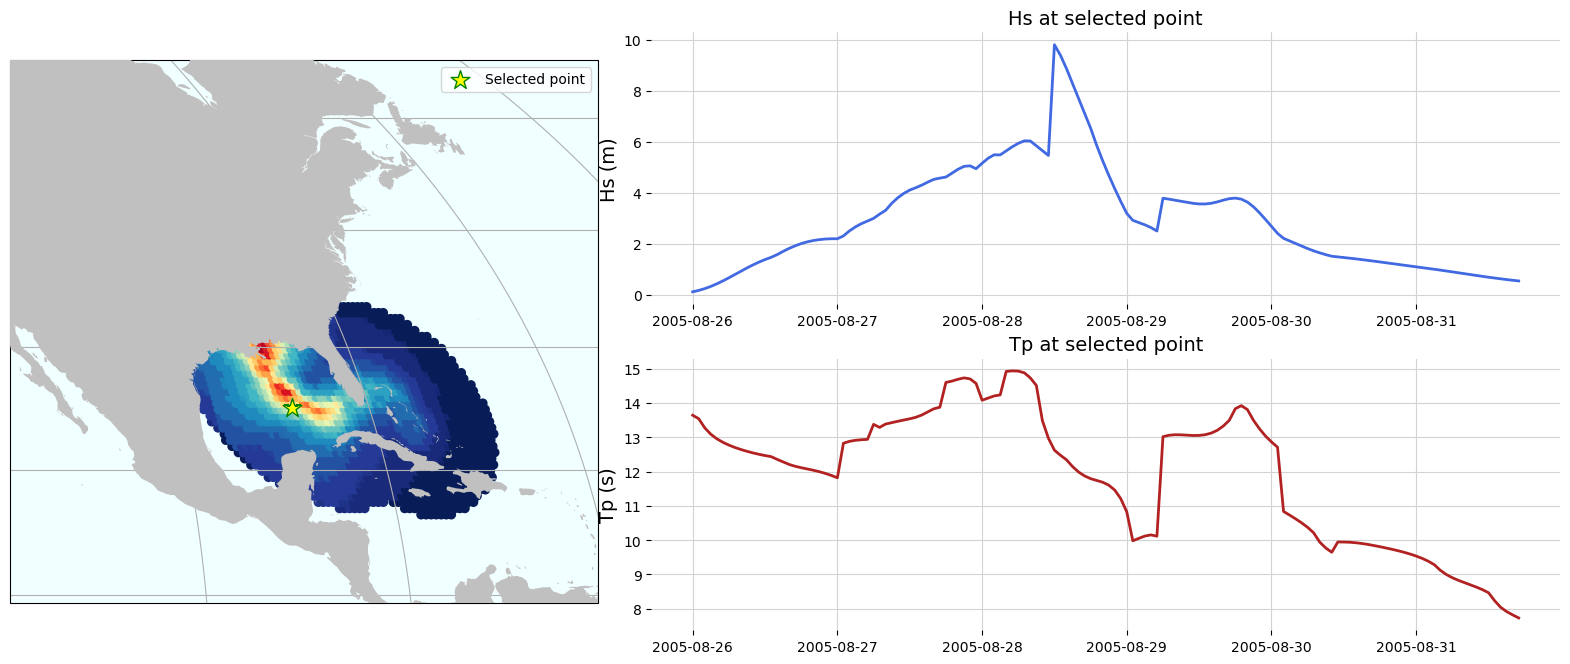

In [16]:
plot_hs_tp_point(xds_bulk, area, lon, lat)

###  **5. Validation**

In [16]:
from bluemath_tk.downloaders.noaa.noaa_downloader import NOAADownloader


noaa_downloader = NOAADownloader(base_path_to_download="NOAA_data")
buoy_df = noaa_downloader.download_data(
    data_type="bulk_parameters",
    load_df=True,
    buoy_id="42040",
    years=[2005],
)
buoy_df.set_index("datetime", inplace=True)
buoy_df

,YYYY,MM,DD,hh,mm,WD,WSPD,GST,WVHT,DPD,APD,MWD,BAR,ATMP,WTMP,DEWP,VIS,TIDE
datetime,,,,,,,,,,,,,,,,,,
2005-01-01 01:00:00,2005,1,1,1,0,95,5.8,6.9,1.88,9.09,6.18,149,1025.1,20.6,21.4,18.6,99.0,99.0
2005-01-01 02:00:00,2005,1,1,2,0,102,7.2,8.4,1.78,9.09,5.73,153,1025.0,20.6,21.4,18.5,99.0,99.0
2005-01-01 03:00:00,2005,1,1,3,0,107,7.0,8.0,2.00,9.09,6.06,153,1025.2,20.7,21.4,18.7,99.0,99.0
2005-01-01 04:00:00,2005,1,1,4,0,107,6.4,7.6,2.01,9.09,5.81,156,1025.6,21.2,21.4,18.7,99.0,99.0
2005-01-01 05:00:00,2005,1,1,5,0,112,6.0,7.1,1.83,9.09,5.64,147,1025.6,21.1,21.4,18.8,99.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-31 19:00:00,2005,12,31,19,0,999,0.0,0.5,0.71,5.26,4.48,135,1013.4,22.9,22.6,999.0,99.0,99.0
2005-12-31 20:00:00,2005,12,31,20,0,999,0.0,0.1,0.67,5.00,4.50,124,1012.9,22.7,22.7,999.0,99.0,99.0
2005-12-31 21:00:00,2005,12,31,21,0,999,6.8,7.9,0.64,5.26,4.42,145,1013.2,21.4,22.8,999.0,99.0,99.0


In [17]:
xds_point = xds_bulk.isel(
    point=np.argmin(
        np.sqrt((xds_bulk.lon.values - lon) ** 2 + (xds_bulk.lat.values - lat) ** 2)
    )
)
xds_point

<xarray.Dataset> Size: 89kB
Dimensions:    (case: 26, time: 198)
Coordinates:
  * case       (case) int64 208B 0 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
  * time       (time) datetime64[ns] 2kB 2005-08-24T06:00:00 ... 2005-09-01T1...
Data variables:
    hs         (case, time) float64 41kB ...
    tp         (case, time) float64 41kB ...
    lon        float64 8B 271.9
    lat        float64 8B 29.4
    ix_near    (case) float64 208B ...
    pos_nonan  (case) float64 208B ...
    bmu        (time) float64 2kB ...
    hsbmu      (time) float64 2kB ...
    tpbmu      (time) float64 2kB ...
    hswath     float64 8B 15.03
    tswath     float64 8B 15.62

<Axes: xlabel='datetime', ylabel='hsbmu'>

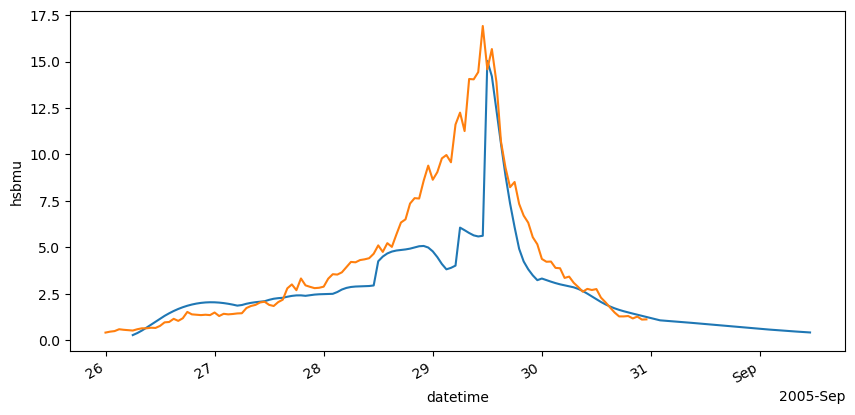

In [18]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 5))
xds_point.hsbmu.plot(ax=ax, x="time")
buoy_df.loc["2005-08-26":"2005-08-30"].WVHT.plot(ax=ax)